In [1]:
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict
from copy import deepcopy

import torch
import torch.nn as nn

from learner import Learner
from meta_learner import Meta_Learner
from mydataset.sinewave import *
from learning import *

In [2]:
class MyArgs:
    def __init__(
        self,
        epoch=10,
        n_way=5,
        k_spt=1,
        k_qry=15,
        imgsz=84,
        imgc=3,
        task_num=4,
        meta_lr=1e-3,
        update_lr=0.01,
        update_step=5,
        update_step_test=10):
        
        self.epoch = epoch
        self.n_way = n_way
        self.k_spt = k_spt
        self.k_qry = k_qry
        self.imgsz = imgsz
        self.imgc = imgc
        self.task_num = task_num
        self.meta_lr = meta_lr
        self.update_lr = update_lr
        self.update_step = update_step
        self.update_step_test = update_step_test

In [3]:
def mixed_pretrained(K, tasks, iterations=500):
    # set up model    
    model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.LeakyReLU(0.01, False)),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.LeakyReLU(0.01, False)),
            ('l3', nn.Linear(40,1))
        ]))
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # fit the model
    for i in range(iterations):
        model.zero_grad()
        x, y = tasks.sample_task().sample_data(K)
        x, y = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)
        loss = criterion(model(x), y)
        loss.backward()
        optimiser.step()
        
    return model

In [4]:
def model_functions_at_training(initial_model, model_name ,sampled_steps, K, x, y, x_axis, optim=torch.optim.SGD, lr=0.001):
    if 'MAML' in model_name:
        model = deepcopy(initial_model.net)
        model.cpu()
    else:
        model = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(1,40)),
            ('relu1', nn.LeakyReLU(0.01, False)),
            ('l2', nn.Linear(40,40)),
            ('relu2', nn.LeakyReLU(0.01, False)),
            ('l3', nn.Linear(40,1))
            ]))
        model.load_state_dict(initial_model.state_dict())

    criterion = nn.MSELoss()
    optimizer = optim(model.parameters(), lr)
    
    num_steps = max(sampled_steps)
    
    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    
    losses = []
    outputs = {}
    for step in range(1, num_steps+1):
        predicted = model(x)
        loss = criterion(predicted, y) / K
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step in sampled_steps:
            outputs[step] = model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
    
    if 'MAML' in model_name:
        outputs['initial'] = initial_model.inference(torch.tensor(x_axis, dtype=torch.float).view(-1, 1).cuda()).cpu().detach().numpy()
    else:
        outputs['initial'] = initial_model(torch.tensor(x_axis, dtype=torch.float).view(-1, 1)).detach().numpy()
        
    return losses, outputs


def plot_sampled_performance(initial_model, model_name, sine_task, K, optim=torch.optim.SGD, lr=0.01):
    
    x_axis = np.linspace(-5, 5, 1000)
    sampled_steps=[1,10]
    x, y = sine_task.sample_data(K)
    losses, outputs = model_functions_at_training(initial_model, 
                                                  model_name,
                                                  sampled_steps=sampled_steps,
                                                  K=K, x=x, y=y,
                                                  x_axis=x_axis,
                                                  optim=optim, lr=lr)

    plt.figure(figsize=(15,5))
    
    # plot the model functions
    plt.subplot(1, 2, 1)
    
    plt.plot(x_axis, sine_task.true_function(x_axis), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x, y, label='data')
    plt.plot(x_axis, outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    
    for step in sampled_steps:
        plt.plot(x_axis, outputs[step], 
                 '-.' if step == 1 else '-', color=(0.5, 0, 0, 1),
                 label='model after {} steps'.format(step))
        
    plt.legend(loc='lower right')
    plt.title("Model fit: {}".format(model_name))

    # plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("Loss over time")
    plt.xlabel("gradient steps taken")
    plt.show()

## K=5

In [5]:
K = 5
args = MyArgs(epoch=200,
              n_way=1,
              k_spt=5,
              k_qry=15,
              imgsz=-1,
              imgc=-1,
              task_num=32,
              meta_lr=1e-3,
              update_lr=0.001,
              update_step=5,
              update_step_test=10)

In [6]:
# batchsz here means total episode number
train_db = Sinewave(
        mode='train',
        batch_size=5000,
        n_way=args.n_way,
        k_shot_spt=args.k_spt, 
        k_shot_qry=args.k_qry,
        amplitude_min=0.1, 
        amplitude_max=5, 
        phase_min=0, 
        phase_max=np.pi, 
        x_min=-5, 
        x_max=5)

valid_db = Sinewave(
        mode='valid',
        batch_size=10,
        n_way=args.n_way,
        k_shot_spt=args.k_spt, 
        k_shot_qry=args.k_qry,
        amplitude_min=0.1, 
        amplitude_max=5, 
        phase_min=0, 
        phase_max=np.pi, 
        x_min=-5, 
        x_max=5)

# test_db = Sinewave(
#         mode='test',
#         batch_size=1,
#         n_way=args.n_way,
#         k_shot_spt=args.k_spt, 
#         k_shot_qry=args.k_qry,
#         amplitude_min=0.1, 
#         amplitude_max=5, 
#         phase_min=0, 
#         phase_max=np.pi, 
#         x_min=-5, 
#         x_max=5)

amp = np.random.uniform(0.1, 5)
pha = np.random.uniform(0, np.pi)
test_task = Sine_Task(amp, pha, -5, 5)

Sine-wave Dataset(train) :
	Batch_size : 5000
	Support sets : 5-shot
	Query sets : 15-shot
Sine-wave Dataset(valid) :
	Batch_size : 10
	Support sets : 5-shot
	Query sets : 15-shot


In [18]:
amp = np.random.uniform(0.1, 5)
pha = np.random.uniform(0, np.pi)
test_task = Sine_Task(amp, pha, -5, 5)

In [7]:
config = [
    ("linear", [40, 1]), # 1 -> 40
    ("leakyrelu", [0.1, False]),
    ("linear", [40, 40]), # 40 -> 40
    ("leakyrelu", [0.1, False]),
    ("linear", [1, 40]), # 40 -> 1
]

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
maml = Meta_Learner(args, config, task='regression')

print(maml)

Meta_Learner(
  (net): Learner(
    linear:(in:1, out:40)
    leakyrelu:(slope:0.100000)
    linear:(in:40, out:40)
    leakyrelu:(slope:0.100000)
    linear:(in:40, out:1)
    
    (vars): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 40x1]
        (1): Parameter containing: [torch.FloatTensor of size 40]
        (2): Parameter containing: [torch.FloatTensor of size 40x40]
        (3): Parameter containing: [torch.FloatTensor of size 40]
        (4): Parameter containing: [torch.FloatTensor of size 1x40]
        (5): Parameter containing: [torch.FloatTensor of size 1]
    )
    (vars_bn): ParameterList()
  )
)


In [8]:
history = train(maml, device, args.epoch, args.task_num, train_db, valid_db, 32, 64)

157it [01:04,  2.43it/s, epoch=1/200, loss=4.251663, acc=0.000]
Mean Train Loss : 6.513477
Mean Train acc  : 0.0000
Mean Valid Loss : 3.380859
Mean Valid acc  : 0.0000

157it [01:09,  2.27it/s, epoch=2/200, loss=5.707863, acc=0.000]
Mean Train Loss : 3.539998
Mean Train acc  : 0.0000
Mean Valid Loss : 3.087891
Mean Valid acc  : 0.0000

157it [01:05,  2.38it/s, epoch=3/200, loss=5.144378, acc=0.000]
Mean Train Loss : 3.012335
Mean Train acc  : 0.0000
Mean Valid Loss : 3.005859
Mean Valid acc  : 0.0000

157it [01:06,  2.36it/s, epoch=4/200, loss=3.965124, acc=0.000]
Mean Train Loss : 2.847535
Mean Train acc  : 0.0000
Mean Valid Loss : 2.894531
Mean Valid acc  : 0.0000

157it [01:07,  2.31it/s, epoch=5/200, loss=5.804447, acc=0.000]
Mean Train Loss : 3.807778
Mean Train acc  : 0.0000
Mean Valid Loss : 2.707031
Mean Valid acc  : 0.0000

157it [01:06,  2.34it/s, epoch=6/200, loss=2.741198, acc=0.000]
Mean Train Loss : 2.809152
Mean Train acc  : 0.0000
Mean Valid Loss : 2.492188
Mean Valid a

In [9]:
pretrain_data = Sine_Task_Distribution(0.1, 5, 0, np.pi, -5, 5)
pretrain_model = mixed_pretrained(K, pretrain_data, iterations=10000)

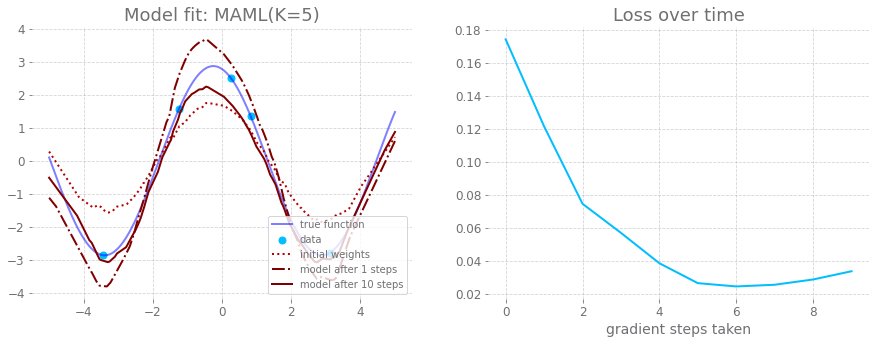

In [19]:
plot_sampled_performance(maml, "MAML(K=5)", test_task, K, optim=torch.optim.SGD, lr=0.01)

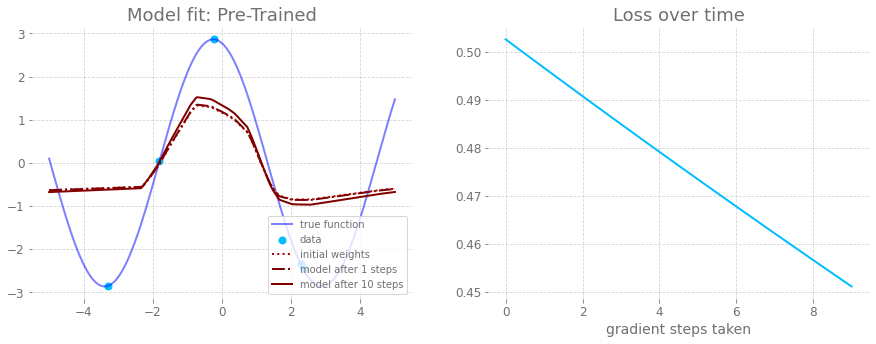

In [20]:
plot_sampled_performance(pretrain_model, "Pre-Trained", test_task, K, optim=torch.optim.SGD, lr=0.01)

In [21]:
with open('history/sinewave_5-shot_train_history.pickle', 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)

## K = 10

In [5]:
K = 10
args = MyArgs(epoch=200,
              n_way=1,
              k_spt=10,
              k_qry=15,
              imgsz=-1,
              imgc=-1,
              task_num=32,
              meta_lr=1e-3,
              update_lr=0.001,
              update_step=5,
              update_step_test=10)

In [6]:
# batchsz here means total episode number
train_db = Sinewave(
        mode='train',
        batch_size=5000,
        n_way=args.n_way,
        k_shot_spt=args.k_spt, 
        k_shot_qry=args.k_qry,
        amplitude_min=0.1, 
        amplitude_max=5, 
        phase_min=0, 
        phase_max=np.pi, 
        x_min=-5, 
        x_max=5)

valid_db = Sinewave(
        mode='valid',
        batch_size=10,
        n_way=args.n_way,
        k_shot_spt=args.k_spt, 
        k_shot_qry=args.k_qry,
        amplitude_min=0.1, 
        amplitude_max=5, 
        phase_min=0, 
        phase_max=np.pi, 
        x_min=-5, 
        x_max=5)

# test_db = Sinewave(
#         mode='test',
#         batch_size=1,
#         n_way=args.n_way,
#         k_shot_spt=args.k_spt, 
#         k_shot_qry=args.k_qry,
#         amplitude_min=0.1, 
#         amplitude_max=5, 
#         phase_min=0, 
#         phase_max=np.pi, 
#         x_min=-5, 
#         x_max=5)

amp = np.random.uniform(0.1, 5)
pha = np.random.uniform(0, np.pi)
test_task = Sine_Task(amp, pha, -5, 5)

Sine-wave Dataset(train) :
	Batch_size : 5000
	Support sets : 10-shot
	Query sets : 15-shot
Sine-wave Dataset(valid) :
	Batch_size : 10
	Support sets : 10-shot
	Query sets : 15-shot


In [7]:
config = [
    ("linear", [40, 1]), # 1 -> 40
    ("leakyrelu", [0.1, False]),
    ("linear", [40, 40]), # 40 -> 40
    ("leakyrelu", [0.1, False]),
    ("linear", [1, 40]), # 40 -> 1
]

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
maml = Meta_Learner(args, config, task='regression')

print(maml)

Meta_Learner(
  (net): Learner(
    linear:(in:1, out:40)
    leakyrelu:(slope:0.100000)
    linear:(in:40, out:40)
    leakyrelu:(slope:0.100000)
    linear:(in:40, out:1)
    
    (vars): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 40x1]
        (1): Parameter containing: [torch.FloatTensor of size 40]
        (2): Parameter containing: [torch.FloatTensor of size 40x40]
        (3): Parameter containing: [torch.FloatTensor of size 40]
        (4): Parameter containing: [torch.FloatTensor of size 1x40]
        (5): Parameter containing: [torch.FloatTensor of size 1]
    )
    (vars_bn): ParameterList()
  )
)


In [8]:
history = train(maml, device, args.epoch, args.task_num, train_db, valid_db, 32, 64)

157it [01:08,  2.28it/s, epoch=1/200, loss=5.524066, acc=0.000]
Mean Train Loss : 6.722845
Mean Train acc  : 0.0000
Mean Valid Loss : 2.576172
Mean Valid acc  : 0.0000

157it [01:09,  2.26it/s, epoch=2/200, loss=3.857538, acc=0.000]
Mean Train Loss : 3.827651
Mean Train acc  : 0.0000
Mean Valid Loss : 2.513672
Mean Valid acc  : 0.0000

157it [01:08,  2.28it/s, epoch=3/200, loss=2.873638, acc=0.000]
Mean Train Loss : 3.879022
Mean Train acc  : 0.0000
Mean Valid Loss : 2.412109
Mean Valid acc  : 0.0000

157it [01:13,  2.14it/s, epoch=4/200, loss=3.372438, acc=0.000]
Mean Train Loss : 3.587608
Mean Train acc  : 0.0000
Mean Valid Loss : 2.302734
Mean Valid acc  : 0.0000

157it [01:11,  2.19it/s, epoch=5/200, loss=2.324229, acc=0.000]
Mean Train Loss : 3.295696
Mean Train acc  : 0.0000
Mean Valid Loss : 2.107422
Mean Valid acc  : 0.0000

157it [01:10,  2.23it/s, epoch=6/200, loss=3.556174, acc=0.000]
Mean Train Loss : 2.564379
Mean Train acc  : 0.0000
Mean Valid Loss : 1.921875
Mean Valid a

In [9]:
pretrain_data = Sine_Task_Distribution(0.1, 5, 0, np.pi, -5, 5)
pretrain_model = mixed_pretrained(K, pretrain_data, iterations=10000)

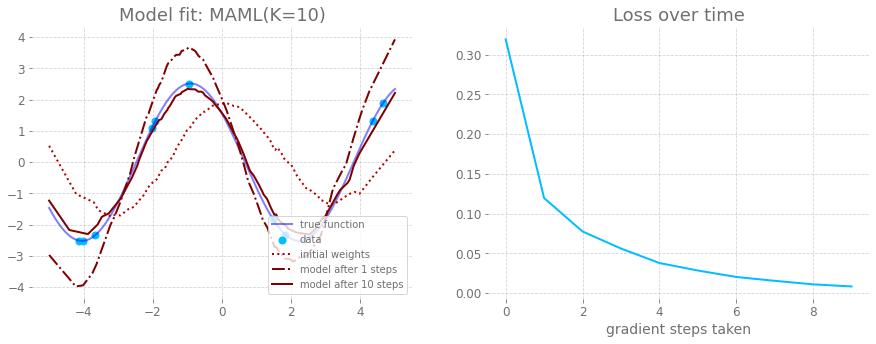

In [10]:
plot_sampled_performance(maml, "MAML(K=10)", test_task, K, optim=torch.optim.SGD, lr=0.01)

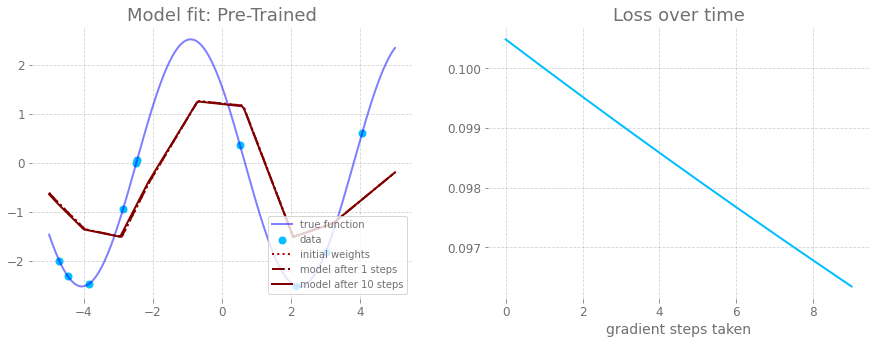

In [11]:
plot_sampled_performance(pretrain_model, "Pre-Trained", test_task, K, optim=torch.optim.SGD, lr=0.01)

In [12]:
with open('history/sinewave_10-shot_train_history.pickle', 'wb') as f:
    pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)